In [1]:
import os
import zipfile
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
import math, random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:
# lr = [os.path.join(lr_dir, f.replace("x2","")) for f in os.listdir(lr_dir)]
# hr = [os.path.join(hr_dir, f.replace("x2","")) for f in os.listdir(hr_dir)]

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, patch_size=96, scale=4, transform=None):
        # self.hr_images = glob.glob(os.path.join(hr_dir, "*.png"))
        # self.lr_images = glob.glob(os.path.join(lr_dir, "*.png"))
        self.patch_size = patch_size
        self.scale = scale
        self.transform = transform
        
        self.hr_images = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.lower().endswith(".png")])
        self.lr_images = sorted([os.path.join(lr_dir, f.replace(f"x{scale}", "")) for f in os.listdir(lr_dir) if f.lower().endswith(".png")])
        self.lr_images = [os.path.splitext(path)[0] + f"x{scale}.png" for path in self.lr_images]


        if len(self.hr_images) != len(self.lr_images):
            print("HR and LR counts differ!")
            
        # Store used corners for each image
        #self.used_corners = {idx: set() for idx in range(len(self.hr_images))}

    def __len__(self):
        return min(len(self.hr_images), len(self.lr_images))

    def random_crop_pair(self, lr, hr, img_idx):
        lr_w, lr_h = lr.size
        hr_w, hr_h = hr.size
        lr_crop = self.patch_size
        hr_crop = lr_crop * self.scale
        
        x = random.randint(0, lr_w - lr_crop)
        y = random.randint(0, lr_h - lr_crop)
        
        # Maybe wanna use this, ensures all patches are used
        # max_attempts = 100
        # attempts = 0
        # while attempts < max_attempts:
        #     x = random.randint(0, lr_w - lr_crop)
        #     y = random.randint(0, lr_h - lr_crop)
        #     if (x, y) not in self.used_corners[img_idx]:
        #         self.used_corners[img_idx].add((x, y))
        #         break
        #     attempts += 1
        # else:
        #     # If all corners exhausted, reset and take this one
        #     self.used_corners[img_idx] = set()
        #     self.used_corners[img_idx].add((x, y))

        lr_patch = lr.crop((x, y, x + lr_crop, y + lr_crop))
        hr_patch = hr.crop((x * self.scale, y * self.scale, (x + lr_crop) * self.scale, (y + lr_crop) * self.scale))
        
        assert hr_patch.size[0] == lr_patch.size[0] * self.scale, \
        f"Width mismatch: {hr_patch.size[0]} vs {lr_patch.size[0]} * {self.scale}"
        assert hr_patch.size[1] == lr_patch.size[1] * self.scale, \
            f"Height mismatch: {hr_patch.size[1]} vs {lr_patch.size[1]} * {self.scale}"
        return lr_patch, hr_patch

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        lr = Image.open(self.lr_images[idx]).convert("RGB")
        lr, hr = self.random_crop_pair(lr, hr, idx)

        if self.transform:
            lr, hr = self.transform(lr, hr)
        else:
            hr = TF.to_tensor(hr)
            lr = TF.to_tensor(lr)
        return lr, hr

In [5]:
target_dir = "datasets/DF2K"
os.makedirs(target_dir, exist_ok=True)

if not any(name.startswith("DF2K_") for name in os.listdir(target_dir)):
    print("Downloading DF2K dataset from Kaggle...")
    exit_code = os.system(f'kaggle datasets download -d anvu1204/df2kdata -p "{target_dir}" --unzip')
    if exit_code == 0:
        print("DF2K dataset downloaded and extracted successfully.")
    else:
        print("Kaggle download failed!")
else:
    print("DF2K dataset already exists. Skipping download.")

DF2K dataset already exists. Skipping download.


In [6]:
class ValSuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, scale=4, transform=None):
        self.scale = scale
        self.transform = transform
        
        self.hr_images = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.lower().endswith(".png")])
        self.lr_images = sorted([os.path.join(lr_dir, f.replace(f"x{scale}", "")) for f in os.listdir(lr_dir) if f.lower().endswith(".png")])
        self.lr_images = [os.path.splitext(path)[0] + f"x{scale}.png" for path in self.lr_images]

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        lr = Image.open(self.lr_images[idx]).convert("RGB")

        if self.transform:
            lr, hr = self.transform(lr, hr)
        else:
            lr = TF.to_tensor(lr)
            hr = TF.to_tensor(hr)
        return lr, hr

In [7]:
# mean  = torch.zeros(3)
# pixel_count = 0
# hr_images = sorted(glob.glob("datasets/DF2K/DF2K_train_HR/*.png"))

# for img_path in tqdm(hr_images):
#     img = Image.open(img_path).convert("RGB")
#     img_tensor = torch.tensor(np.array(img) / 255.0)  # HWC, [0,1] float
#     img_tensor = img_tensor.permute(2, 0, 1)           # CHW
    
#     # Sum over all pixels per channel
#     mean += img_tensor.sum(dim=(1,2))
#     pixel_count += img_tensor.shape[1] * img_tensor.shape[2]
    
# mean_rgb = mean / pixel_count
# print("Dataset mean RGB:", mean_rgb)

mean_rgb = [0.4689, 0.4490, 0.4034]
#mean_rgb = [0.4488, 0.4371, 0.4040]  # EDSR paper

In [8]:
class RandomSRTransform:
    def __init__(self, scale=4):
        self.scale = scale
        self.mean = torch.FloatTensor(mean_rgb).view(3,1,1)

    def __call__(self, lr, hr):
        # --- Random horizontal flip ---
        if random.random() < 0.5:
            lr = TF.hflip(lr)
            hr = TF.hflip(hr)

        # --- Random 90/180/270 degree rotations ---
        if random.random() < 0.5:
            angle = random.choice([90, 180, 270])
            lr = TF.rotate(lr, angle)
            hr = TF.rotate(hr, angle)

        # --- Convert to tensor and subtract mean ---
        lr = TF.to_tensor(lr)
        hr = TF.to_tensor(hr)
        lr = lr - self.mean
        hr = hr - self.mean

        return lr, hr

In [9]:
scale = 4

train_dataset = SuperResolutionDataset(hr_dir="datasets/DF2K/DF2K_train_HR",
    lr_dir=f"datasets/DF2K/DF2K_train_LR_bicubic/X{scale}",
    patch_size=48,
    scale=scale,
    transform=RandomSRTransform(scale=scale)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True) # num workers doesnt work with tqdm on windows wtf


mean_tensor = torch.FloatTensor(mean_rgb).view(3,1,1)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x - mean_tensor)
])

val_dataset = ValSuperResolutionDataset(
    hr_dir="datasets/DF2K/DF2K_valid_HR",
    lr_dir=f"datasets/DF2K/DF2K_valid_LR_bicubic/X{scale}",
    scale=scale,
    transform=lambda lr, hr: (val_transform(lr), val_transform(hr))
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39831176..0.46326667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39831176..0.569149].


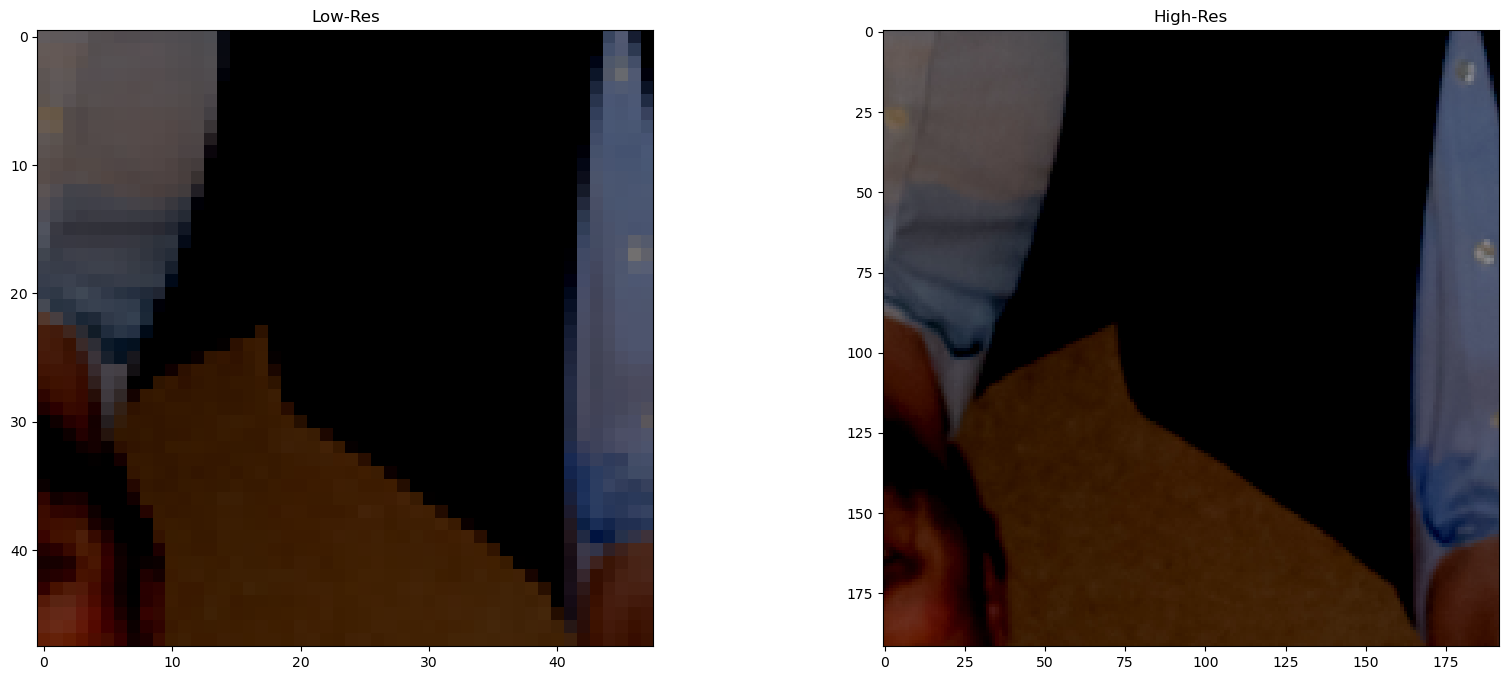

In [10]:
lr, hr = train_dataset[np.random.choice(range(len(train_dataset)))]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1); plt.imshow(lr.permute(1,2,0)); plt.title("Low-Res")
plt.subplot(1,2,2); plt.imshow(hr.permute(1,2,0)); plt.title("High-Res")
plt.show()
    #input("Press Enter for next image...")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39409804..0.5966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42154902..0.5966].


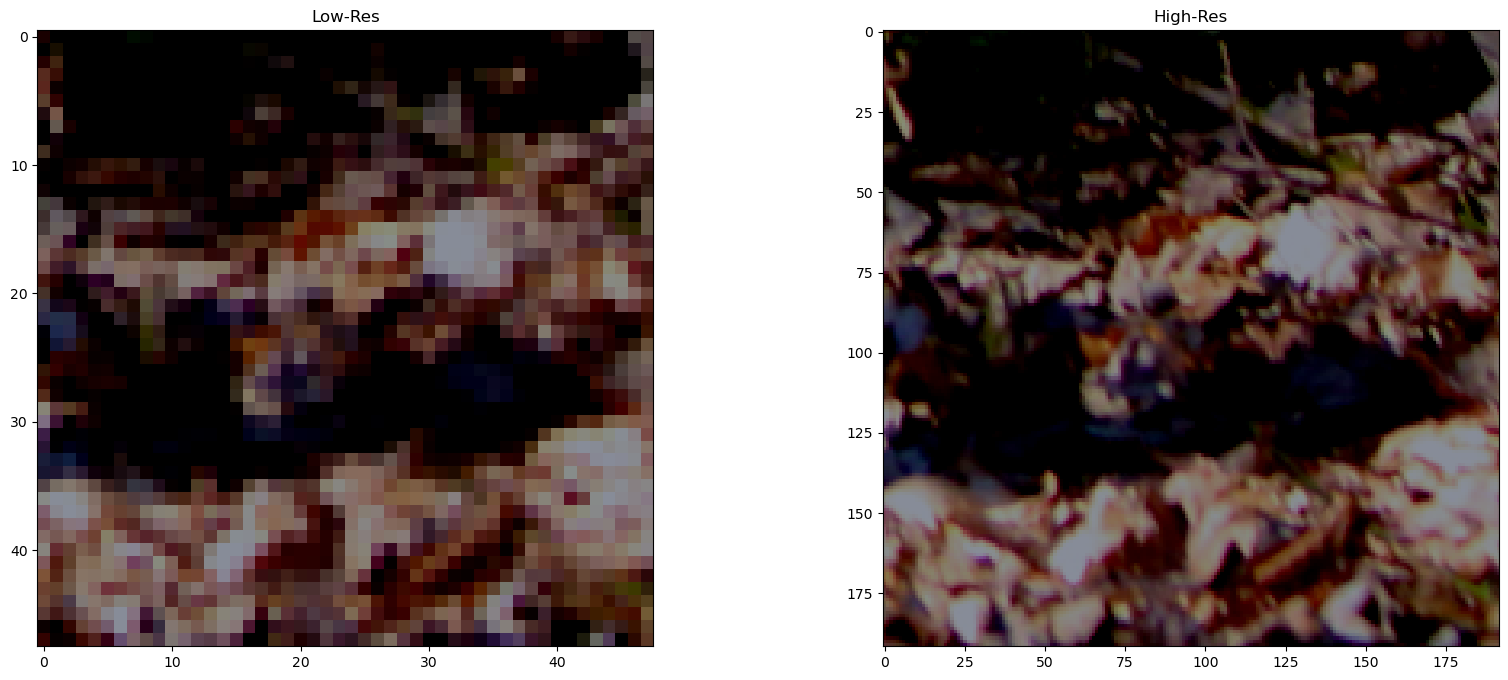

In [11]:
#print((next(iter(train_loader)))[0][0])
lr, hr = next(iter(train_loader))
lr = lr[0]
hr = hr[0]
plt.figure(figsize=(20,8))
plt.subplot(1,2,1); plt.imshow(lr.permute(1,2,0)); plt.title("Low-Res")
plt.subplot(1,2,2); plt.imshow(hr.permute(1,2,0)); plt.title("High-Res")
plt.show()

In [12]:
class ResidualBlockNoBN(nn.Module):
    def __init__(self, num_feats=64, res_scale=0.1):
        super().__init__()
        self.res_scale = res_scale
        self.conv1 = nn.Conv2d(num_feats, num_feats, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_feats, num_feats, 3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res) * self.res_scale
        return x + res

In [13]:
class Upsampler(nn.Module):
    def __init__(self, scale, n_feats):
        super().__init__()
        layers = []
        if scale in (2, 4, 8):
            for _ in range(int(math.log(scale, 2))):
                layers += [
                    nn.Conv2d(n_feats, 4 * n_feats, 3, padding=1),
                    nn.PixelShuffle(2),
                    nn.ReLU(True)
                ]
        elif scale == 3:
            layers += [
                nn.Conv2d(n_feats, 9 * n_feats, 3, padding=1),
                nn.PixelShuffle(3),
                nn.ReLU(True)
            ]
        else:
            raise ValueError(f"Unsupported scale: {scale}")
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
class EDSR(nn.Module):
    def __init__(self, scale_factor=4, num_blocks=16, num_feats=64, res_scale=0.1):
        super().__init__()
        self.head = nn.Conv2d(3, num_feats, 3, padding=1)

        body = [ResidualBlockNoBN(num_feats, res_scale=res_scale) for _ in range(num_blocks)]
        body.append(nn.Conv2d(num_feats, num_feats, 3, padding=1))
        self.body = nn.Sequential(*body)

        self.upsample = Upsampler(scale_factor, num_feats)
        self.tail = nn.Conv2d(num_feats, 3, 3, padding=1)

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        x = x + res
        x = self.upsample(x)
        x = self.tail(x)
        return x

In [15]:
def calc_psnr_rgb(sr, hr, scale=4):
    border = scale + 6 # 6 + scale pixels ignored
    # crop borders
    sr_crop = sr[:, :, border:-border, border:-border]
    hr_crop = hr[:, :, border:-border, border:-border]
    mse = torch.mean((sr_crop - hr_crop) ** 2)
    if mse == 0:
        return 100
    return 10 * torch.log10(1 / mse)

In [16]:
def rgb_to_y(img):
    """
    Convert RGB image tensor to Y channel (luminance).
    img: [B,3,H,W], values in [0,1]
    Returns: [B,1,H,W]
    """
    r, g, b = img[:,0:1,:,:], img[:,1:2,:,:], img[:,2:3,:,:]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    return y

def calc_psnr(sr, hr, scale=4):
    """
    Compute PSNR between super-resolved (sr) and high-res (hr) images on Y channel.
    sr, hr: [B,3,H,W], values in [0,1]
    scale: super-resolution scale factor (used for border cropping)
    """
    border = scale  + 6

    sr_y = rgb_to_y(sr)
    hr_y = rgb_to_y(hr)
 
    sr_crop = sr_y[:, :, border:-border, border:-border]
    hr_crop = hr_y[:, :, border:-border, border:-border]
    mse = torch.mean((sr_crop - hr_crop) ** 2)
    if mse == 0:
        return 100.0
    return 10 * torch.log10(1.0 / mse)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EDSR(scale_factor=scale, num_blocks=16, num_feats=64, res_scale=1.0).to(device)

lr = 1e-4
criterion = nn.L1Loss() # l1 loss better than l2 according to paper
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
print(f"Training on {device} with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")

Training on cuda with 1.52M parameters


In [18]:
#model.load_state_dict(torch.load("edsr_best_x2_big.pth", weights_only=True))

In [ ]:
EPOCHS = 250
best_psnr = 0
all_psnr = []
losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch}/{EPOCHS}]", leave=False)
    
    for lr, hr in pbar:
        lr, hr = lr.to(device), hr.to(device)
        
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.4) # Not in the paper
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.4) # Not in the paper
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # Validation
    model.eval()
    psnrs = []
    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            sr = sr + mean_tensor.to(device)
            hr = hr + mean_tensor.to(device)
            sr = torch.clamp(sr, 0.0, 1.0)
            
            # Compute per-image PSNR
            for i in range(sr.size(0)):
                psnrs.append(calc_psnr(sr[i:i+1], hr[i:i+1], scale))

    avg_psnr = sum(psnrs) / len(psnrs)

    print(f"Epoch {epoch:03d}: Loss={avg_loss:.6f}, Val PSNR={avg_psnr:.3f} dB")
    all_psnr.append(avg_psnr)

    # Save best checkpoint
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(model.state_dict(), f"edsr_best_x{scale}.pth")
        print(f"Saved new best model (PSNR={best_psnr:.3f})")

print("Training completed.")

Epoch 001: Loss=0.071399, Val PSNR=25.246 dB
Saved new best model (PSNR=25.246)


Epoch 002: Loss=0.043148, Val PSNR=26.393 dB
Saved new best model (PSNR=26.393)


Epoch [3/250]:  19%|█▊        | 40/216 [00:58<04:02,  1.38s/it, loss=0.0387]

In [ ]:
model.eval()
with torch.no_grad():
    for lr, hr in val_loader:
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)
        sr = sr + mean_tensor.to(device)
        hr = hr + mean_tensor.to(device)
        sr = torch.clamp(sr, 0.0, 1.0)
        lr = lr + mean_tensor.to(device)
        from torchvision.utils import save_image
        save_image(sr, "super_res.png")
        save_image(lr, "low_res.png")
        
        break